# <center>**Atelier : Classification**</center>

### Documentation : https://scikit-learn.org/stable/modules/neighbors.html#classification

### **1. Setup**
Avant de commencer, pour s’assurer du bon fonctionnement du notebook, quelques commandes doivent être lancées dans un premier temps. Taper ce code dans la première cellule du notebook :

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# Make figures plots easier
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### **2. MNIST**

Nous allons utiliser le jeu de données MNIST, composé de 70.000 images de chiffres.

Récupérons le jeu de données grâce à la fonction utilitaire `fetch_openml()` mise à disposition dans scikit-learn :

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    #sort_by_target(mnist) # fetch_openml() renvoie un jeu de données non triées
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([5, 0, 4, ..., 4, 5, 6], dtype=int8))

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Les jeux de données `datasets` que charge scikit-learn ont en général une structure de dictionnaire similaire :
- une clé `DESCR` décrivant le jeu de données
- une clé `data` contenant un tableau avec une ligne par observation et une colonne par variable
- et enfin une clé `target` contenant un tableau d'étiquettes

Voyons ces tableaux :

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

Il y a 70.000 images comportant chacune 784 valeurs, ceci parce que chaque image comporte 28 x 28 pixels et chaque valeur représente simplement l'intensité d'un pixel, de 0 (blanc) à 255 (noir).

Examinons l'un des chiffres de ce jeu de données. Il suffit de récupérer le vecteur des valeurs (ou caractéristiques) d'une observation, de le convertir en tableau 28 x 28 et de l'afficher en utilisant la fonction `imshow()` de Matplotlib :

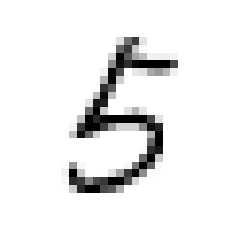

In [6]:
some_digit = X[396]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

Cela ressemble à un 5 et c'est bien ce qu'indique l'étiquette :

In [9]:
y[396]

5

L'étiquette est une chaîne de caractères.

La plupart des algorithmes de Machine Learning attendant des nombres, nous allons forcer y au type entier :

In [8]:
y = y.astype(np.uint8)

Ci-dessous des fonctions qui vous nous être utiles pour représenter visuellement les données :

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Visualisations quelques images du jeu de données MNIST pour nous sensibiliser à la complexité de la tâche de classification :

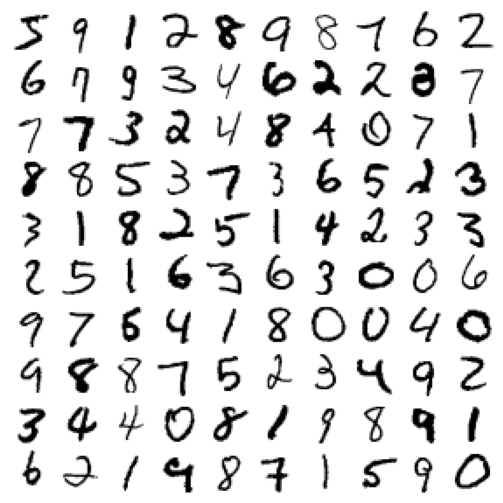

In [10]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)

plt.show()

Avant d'inspecter les données et d'aller plus loin, nous devons créer un jeu de test et le mettre de côté.

En pratique, les données MNIST sont déjà partagées entre un jeu d'entraînement (les 60.000 premières images) et un jeu de test (les 10.000 dernières images) :

In [11]:
X_train, X_test, y_train, y_test = , , , 

Le jeu d'entraînement est déjà mélangé pour nous, ce qui est une bonne chose pour garantir l'homogénéité de toutes les passes de validation croisée (afin d'éviter qu'il manque des chiffres dans certains échantillons).

*Remarque*:
- certains algorithmes sont sensibles à l'ordre des observations d'entraînement et peuvent donner de mauvais résultats s'ils reçoivent beaucoup de données similaires à la suite
- pour éviter cela, on mélange en général les données
- dans certains contextes, mélanger peut ne pas être judicieux, par exemple si vous travaillez sur des séries temporelles (telles que les cours boursiers ou des relevés bancaires)

### **3. ENTRAÎNEMENT D'UN CLASSIFICATEUR BINAIRE**

Nous allons simplifier le problème pour l'instant en nous contentant d'identifier un chiffre, par exemple le 5.

Ce "détecteur de 5" sera un exemple de classificateur binaire, capable d'effectuer la distinction entre deux classes uniquement, 5 et non-5.

Créons les deux vecteurs cible pour cette tâche de classification :

In [12]:
y_train_5 =  #vrai pour les 5, faux pour le reste
y_test_5 = 

Une bonne idée consiste à commencer par un classificateur de descente de gradient stochastique en utilisant la classe `SGDClassifier`.

Ce classificateur présente l'avantage de savoir gérer efficacement des jeux de données très volumineux (en particulier parce que la méthode SGD traite indépendamment et tour à tour chacune des observations d'apprentissage).

Créons un `SGDClassifier` et entraînons-le sur l'ensemble du jeu d'entraînement :

In [13]:
from sklearn. import 

sgd_clf = 
sgd_clf.

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

*Remarque*:

- durant l'entrainement le `SGDClassifier` s'appuie sur un processus aléatoire, d'où le nom stochastique
- si l'on veut reproduire nos résultats, nous devons donner une valeur au paramètre `random_state`

Maintenant, nous pouvons l'utiliser pour détecter les images représentant des 5 :

In [14]:
sgd_clf.

array([ True])

Le classificateur détermine que cette image représente un 5 (valeur `True`) : il semble avoir deviné juste dans ce cas particulier !

Nous allons maintenant évaluer les performances du modèle.

### **4. MESURES DE PERFORMANCES**

#### **4.1. Mesurer l'exactitude à l'aide de la validation croisée**

Un bon moyen d'évaluer un modèle est d'effectuer une validation croisée.

Parfois, un meilleur contrôle du processus de validation croisée que celui fourni en standard par scikit-learn (la fonction `cross_val_score()`) est nécessaire.

C'est pourquoi nous allons dans notre cas implémenter nous-même notre validation croisée :

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.(X_train_folds, y_train_folds)
    y_pred = clone_clf.(X_test_fold)
    n_correct = sum( == )
    print(n_correct / len(y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.9633
0.95695
0.9146


La classe `StratifiedKFold` effectue à chaque passe un échantillonage stratifié pour produire des blocs contenant un ratio représentatif de chaque classe.

A chaque itération, le code crée un clone du classificateur, l'entraîne sur les blocs d'entraînement et effectue des prédictions sur le bloc de test.

Puis il compte le nombre de prédictions correctes et imprime le pourcentage de prédictions correctes.

Utilions la fonction `cross_val_score()` pour évaluer notre modèle `SGDClassifier` à l'aide d'une validation croisée à K passes avec ici K=3 :

In [16]:
from sklearn. import 
cross_val_score( , , , , scoring="accuracy")

array([0.9633 , 0.95695, 0.9146 ])

Nous obtenons un taux d'exactitude de 91% sur tous les blocs de validation croisée.

A titre de comparaison, examinons un classificateur dénué de toute intelligence qui se contente de classer chaque image dans la classe "non-5" :

In [17]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Voyons son taux d'exactitude :

In [18]:
never_5_clf = 
cross_val_score(, , , cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Il est supérieur à 90% !

C'est simplement parce que les 5 ne représente qu'environ 10% des images et donc si l'on décide à chaque fois qu'une image n'est pas un 5, nous aurons raison dans à peu près 90% des cas.

Ceci démontre que l'exactitude n'est pas en général la mesure de performance de prédilection pour les classificateurs, surtout lorsque l'on a affaire à des jeux de données asymétriques dans lesquels certaines classes sont bien plus fréquentes que d'autres.

#### **4.2. Matrice de confusion**

Pour construire la matrice de confusion, il nous faut d'abord un ensemble de prédictions afin de pouvoir les comparer aux véritables valeurs cibles.

Nous allons utiliser la fonction `cross_val_predict()`:

In [19]:
from sklearn. import 

y_train_pred = (, , , cv=3)

Tout comme la fonction `cross_val_score()`, `cross_val_predict()` effectue une validation croisée à K passes : au lien de renvoyer les scores d'évaluation, elle renvoie les prédictions faites sur chaque bloc de test.

Cela signifie que l'on obtient une prédiction saine pour chaque observation du jeu d'entraînement ("saine" signifie que la prédiction est faite par un modèle qui n'a jamais rencontré ces données durant l'entraînement).

Il nous suffit maintenant d'utiliser la fonction `confusion_matrix()` pour obtenir la matrice de confusion, en lui transmettant les classes cibles (`y_train_5`) et les classes prédites (`y_train_pred`) :

In [20]:
from sklearn. import 



array([[52336,  2243],
       [ 1060,  4361]], dtype=int64)

Chaque ligne de la matrice de confusion représente une classe réelle, tandis que chaque colonne représente une classe prédite.
- La $1^{ère}$ ligne de cette matrice correspond aux images non-5 (la classe négative) :
  - 52.336 de ces images ont été correctement classées en non-5 (on les appelle les vrais négatifs)
  - les 2.243 images restantes ont été classées à tort en 5 (faux positifs)
- La $2^{ème}$ ligne de la matrice correspond aux images de 5 (la classe positive) :
  - 1.060 ont été classées par erreur en non-5 (faux négatifs)
  - les 4.361 restantes ont été correctement classées en 5 (vrais positifs)

Un classificateur parfait n'aurait que des vrais positifs et des vrais négatifs et sa matrice de confusion n'aurait donc des valeurs non nulles que sur sa diagonale principale :

In [21]:
y_train_perfect_predictions = 

confusion_matrix(, )

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### **4.3. Précision et rappel**

Bien que la matrice de confusion nous fournisse beaucoup de renseignements, il peut être intéressant d'étudier l'exactitude des prédictions positives : c'est ce qu'on appelle la précision d'un classificateur.

Scikit-learn fournit plusieurs fonctions permettant de calculer des métriques pour classificateur, parmis lesquelles la précision (`precision_score`) et le rappel (`recall_score`) : 

In [22]:
from sklearn. import , 



0.6603573591762568

In [23]:
4361 / (4361 + 2243)

0.6603573591762568

0.8044641210108836

In [25]:
4361 / (4361 + 1060)

0.8044641210108836

Maintenant, notre détecteur de 5 ne parraît pas très brillant : lorsqu'il déclare qu'un image est 5, il n'a raison que 66% du temps ; de plus il ne détecte que 80,4% des 5.

Calculons le score $F_1$ de notre détecteur en appelant simplement la fonction `f1_score()` :

In [26]:
from sklearn. import 


0.7253222453222454

In [27]:
4361 / (4361 + (1060 + 2243)/2)

0.7253222453222453

*Remarque:*

Le score $F_1$ favorise les classificateurs ayant une précision et un rappel similaires (ce qui n'est pas notre cas).

Ce n'est pas toujours ce qui est recherché (dans cetrains contextes, on se soucie essentiellement de la précision et dans d'autres du rappel).

#### **4.4. Compromis précision/rappel**

scikit-learn ne permet pas de définir directement le seuil mais il donne accès aux scores de décision qu'il utilise pour effectuer ses prédictions.

Au lieu d'appeler la méthode `predict()` du classificateur, nous pouvons appeler sa méthode `decision_function()` qui renvoie un score pour chaque observation, puis effectuer des prédictions en fonction de ces scores en utilisant le seuil que nous voulons :

In [28]:
y_scores = sgd_clf.([some_digit])
y_scores

array([46936.88298727])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

Le `SGDClassifier` utilise ici un seuil égal à 0, ce qui correspond au même résultat que la méthode `predict()`.

Réhaussons maintenant ce seuil :

In [30]:
threshold = 100000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Ceci confirme qu'augmenter le seuil fait décroître le rappel : l'image représente effectivement un 5 et le classificateur le détecte lorsque le seuil est à 0 mais n'y arrive pas lorsque le seuil est augmenté à 100.000.

Comment pouvons décider du seuil à utiliser ? Il faut d'abord obtenir les scores de toutes les observations du jeu d'entraînement en utilisant la fonction `cross_val_predict()` mais en spécifiant cette fois que nous voulons qu'elle renvoie les scores de décision plutôt que des prédictions :

In [31]:
y_scores = cross_val_predict(, , , cv=3,method=)

Avec ces scores, nous pouvons maintenant calculer la précision et le rappel pour tous les seuils possibles en utilisant la fonction `precision_recall_curve()` :

In [32]:
from sklearn. import 

precisions, recalls, thresholds = 

Utilisons Matplotlib pour représenter la précision et le rappel en tant que fonctions du seuil :

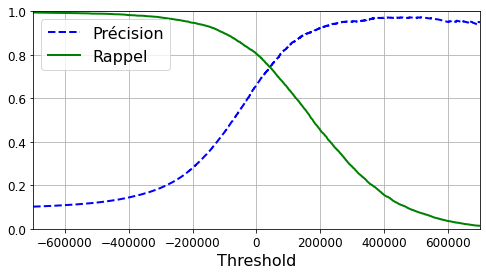

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Précision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Rappel", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(, , )
plt.xlim([-700000, 700000])
plt.grid()

plt.show()

*Remarque:*
- la courbe de précision est plus irrégulière que la courbe de rappel : la raison est que la précision peut parfois diminuer lorsque l'on augmente le seuil (alors qu'en général elle augmente).

Une autre façon de sélectionner un bon compromis précision/rappel consiste à croiser directement la précision avec le rappel :

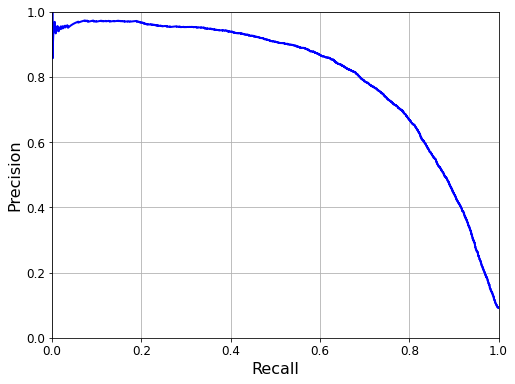

In [34]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(, )
plt.grid()
plt.show()

Nous pouvons voir que la précision commence à chuter brutalement aux environs de 80% de rappel.

Nous souhaiterions probablement sélectionner un compromis précision/rappel juste avant cette chute brutale, par exemple aux alentours d'un rappel de 60% (le choix final dépend bien évidemment du projet).

#### **4.5. La courbe ROC**

Pour tracer la courbe ROC, nous devons d'abord calculer le taux de vrais positifs (tpr = true positive rate) et le taux de faux positifs (fpr = false positive rate) à l'aide de la fonction `roc_curve()` :

In [35]:
from sklearn. import 

fpr, tpr, thresholds = 

Puis nous pouvons croiser ces variables `fpr` et `tpr` grâce à Matlplotlib :

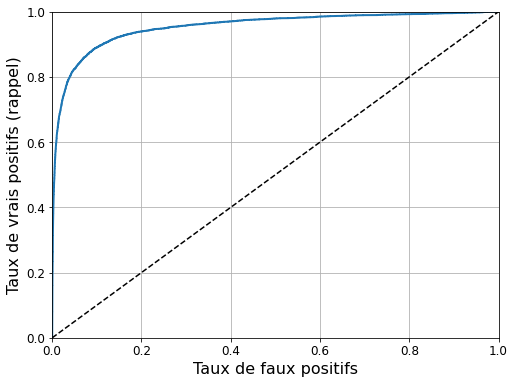

In [36]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taux de faux positifs', fontsize=16)
    plt.ylabel('Taux de vrais positifs (rappel)', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(, )

plt.grid()
plt.show()

Une fois encore, il faut faire un compromis : plus le rappel est haut, plus le classificateur produit de faux positifs.

La ligne pointillée représente la courbe ROC d'un classificateur purement aléatoire : un bon classificateur s'en écarte autant que possible (vers le coin supérieur gauche).

Dans notre cas, on pourrait considérer que notre classificateur est vrament bon en regardant cette courbe ROC : mais c'est essentiellement parce q'il y a peu de positifs (5) par rapport aux négatifs (non-5).

Par contraste, la courbe PR montre clairement que le classificateur peut être amélioré, la courbe pouvant se rapprocher davantage du coin supérieur gauche.

Une façon de comparer les classificateurs consiste à mesurer l'aire "sous la courbe" (Area Under the Curve ou AUC) :
- un classificateur parfait aurait une aire sous la courbe ROC (ou ROC AUC) égale à 1
- un classificateur purement aléatoire aurait une ROC AUC de 0.5

Calculons la ROC AUC avec la fonction fournie par scikit-learn `roc_auc_score()` :

In [37]:
from sklearn. import 



0.9536789698168869

*Remarque:*:
- la courbe ROC étant similaire à la courbe PR, on va en général :
    - préférer la courbe PR si la classe positive est rare ou si l'on accorde davantage d'importance aux faux positifs qu'aux faux négatifs
    - préférer la courbe ROC dans le cas contraire

Nous allons maintenant un `RandomForestClassifier` et comparons sa courbe ROC et son score ROC AUC à ceux du `SGDClassifier`.

Premièrement, nous devons obtenir un score pour chaque observation du jeu d'entraînement ; mais en raison de son mode de fonctionnement, la classe `RandomForestClassifier` ne possède pas de méthode `decision_function()` .

Elle possède à la place une méthode `predict_proba()` qui renvoie un tableau comportant une ligne par observation et une colonne par classe, chaque cellule contenant la probabilité que l'observation appartienne à la classe :

In [38]:
from sklearn. import 
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(, , , cv=3,method=)

La fonction `roc_curve()` attend des étiquettes et des scores en entrée, mais nous pouvons lui attribuer des probabilités de classe au lieu des scores (ici nous allons utiliser la probabilité de la classe positive en tant que score) :

In [39]:
y_scores_forest = y_probas_forest[:, 1] # score = proba de la classe positive
fpr_forest, tpr_forest, thresholds_forest = 

Nous pouvons maintenant tracer la courbe ROC avec la première courbe ROC pour pouvoir les comparer :

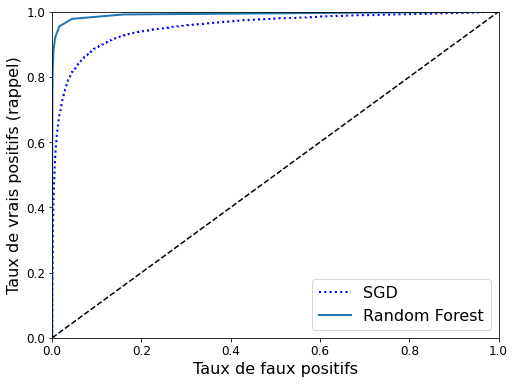

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(, , "Random Forest")
plt.legend(loc="lower right", fontsize=16)

plt.show()

La courbe du ROC du `RandomForestClassifier` semble bien meilleure que celle du `SGDClassifier` : elle est beaucoup plus proche du coin supérieur gauche.

Regardons le score ROC AUC du `RandomForestClassifier` ainsi que sa précision et son rappel :

0.9920527492698306

In [42]:
y_train_pred_forest = cross_val_predict(, , , cv=3)


0.986046511627907

0.8212506917542889

Ces scores sont pas mal !

### **5. CLASSIFICATION MULTI-CLASSES**

Lorsque l'on essaie d'utiliser un algorithme de classification binaire pour une tâche de classification multi-classes, scikit-learn le détecte et applique automatiquement une stratégie OvR ou OvO selon l'algorithme.

Essayons ceci sur un classificateur de type SVM en utilisant la classe `sklearn.svm.svc` :

In [44]:
from sklearn. import 
svm_clf = 
svm_clf. #y_train et non pas y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Nous venons d'entraîner un `SVC` sur le jeu d'entraînement en utilisant les cibles originelles de 0 à 9 (`y_train`) et non les classes 5-contre-le-reste (`y_train_5`), puis nous avons fait une prédiction (correcte dans ce cas).

Si l'on regarde sous le capot, scikit-learn a en réalité utilisé la startégie OvO : il a entraîné 45 classificateurs binaires, récupéré leur score de décision pour cette image et sélectionné la classe ayant gagné le plus de duels.

En appelant la méthode `decision_function()`, nous pouvons voir qu'elle renvoie 10 scores par observations (au lieu d'un seul), soit un score par classe :

In [45]:
some_digit_scores = svm_clf.
some_digit_scores

array([[ 3.83040372,  0.71044021,  2.75291578,  8.28768902,  2.76060783,
         9.30957211,  5.98398504, -0.29752824,  7.24673312,  3.85644369]])

Le plus haut score est effectivement celui qui correspond à la classe 5 :

5

In [47]:
svm_clf.

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [48]:
svm_clf.classes_[5]

5

*Remarques:*

- lorsqu'un classificateur est entraîné, il range la liste des classes cibles dans son attribut `classes_`, classées par valeur
- dans notre cas, l'indice de chaque classe dans le tableau `classes_` correspond for heureusement à la classe elle-même mais en général, nous n'aurons pas tant de chance

Nous pouvons également directement utiliser les classes `OneVsOneClassifier` ou `OneVsRestClassifier` pour obliger scikit-learn à utiliser la méthode "un contre un" ou "un contre le reste".

Créons par exemple un classificateur multi-classe en utilisant une stratégie OvR basé sur un SVC :

In [50]:
from sklearn. import 
ovr_clf = 
ovr_clf.
ovr_clf.

array([5], dtype=uint8)

In [55]:
len(ovr_clf.estimators_)

10

Entraîner un `SGDClassifier` (ou un `RandomForestClassifier`) est tout aussi simple :

In [56]:
sgd_clf.
sgd_clf.

array([5], dtype=uint8)

Cette fois, scikit-learn n'a pas eu besoin de stratégie OvO ou OvR car un `SGDClassifier` peut répartir directement les observations entre plusieurs classes.

La méthode `decision_function()` retourne maintenant une valeur par classe :

In [57]:
sgd_clf.

array([[-108974.17039192, -514716.29828139, -190167.55514981,
           3391.74763525,  -58281.57896257,   51940.28196088,
        -253164.40984313, -449390.15405998, -198922.71148623,
        -143408.78749749]])

Nous pouvons voir que le classificateur est plutôt confiant dans sa prédiction : presque tous les scores sont largement négatifs tandis que la classe 5 a un score de 51.940,28.

Nous pouvons également voir que le modèle a un léger doute sur la classe 3, qui obtient un score de 3.391,7.

Evaluons maintenant ce classificateur en utilisant la validation croisée :

array([0.8684 , 0.85975, 0.85475])

Il obtient un score de 85% sur tous les blocs. Considérant qu'un classificateur purement aléatoire aurait une exactitude de 10%, ce résultat n'est donc pas mauvais.

Mais il y a possibilité de faire beaucoup mieux.

Par exemple, normalisons simplement les données d'entrée et réévaluons l'exactitude du classificateur :

In [59]:
from sklearn. import 
scaler = 
X_train_scaled = scaler.(X_train.astype(np.float64))
cross_val_score( , , , cv=3, scoring="accuracy")

array([0.906  , 0.9074 , 0.91205])

Une simple normalisation des données d'entrée a permis d'avoir une exactitude de plus de 90%.

### **6. ANALYSE DES ERREURS**

Pour chercher comment améliorer un modèle prometteur, un des moyens à notre disposition consiste à analyser les erreurs qu'il fait.

Examinons tout d'abord la matrice de confusion :

In [60]:
y_train_pred = 
conf_mx = 
conf_mx

array([[5734,    2,   26,    9,   11,   45,   42,    9,   41,    4],
       [   1, 6482,   42,   31,    7,   40,    6,    9,  112,   12],
       [  58,   41, 5293,  106,   90,   31,   93,   60,  169,   17],
       [  49,   40,  143, 5322,    4,  236,   37,   57,  150,   93],
       [  25,   25,   33,    9, 5359,    8,   54,   29,   95,  205],
       [  77,   44,   38,  180,   81, 4603,   99,   23,  183,   93],
       [  36,   31,   42,    2,   41,  102, 5617,    3,   44,    0],
       [  31,   26,   73,   34,   57,   14,    3, 5750,   19,  258],
       [  48,  164,   69,  139,   12,  160,   49,   21, 5054,  135],
       [  44,   35,   23,   89,  153,   39,    2,  186,   83, 5295]],
      dtype=int64)

Il est souvent plus pratique d'examiner une représentation graphique de la matrice de confusion, obtenue grâce à la fonction `matshow()` de Matplotlib :

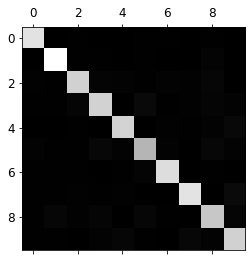

In [61]:
plt.matshow(, cmap=plt.cm.gray)
plt.show()

Si vous préférez une représentation graphique colorée :

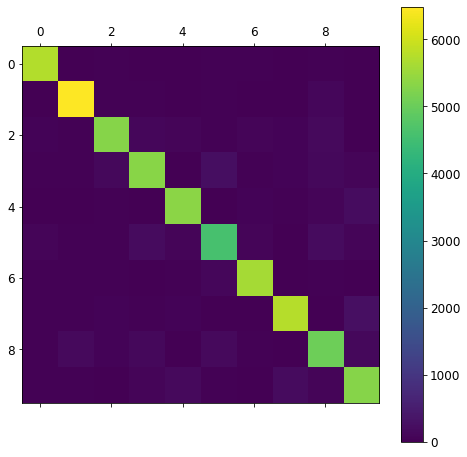

In [62]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)



Cette matrice de confusion semble plutôt satisfaisante étant donné que la plupart des images sont sur la diagonale principale, ce qui signifie qu'elles ont été classées correctement.

Les 5 paraissent sensiblement plus sombres que les autres chiffres, ce qui peut signifier qu'il y a moins de 5 dans le jeu de de données ou que le classificateur ne donne pas d'aussi bons résultats sur les 5 que sur les autres chiffres (on pourra vérifier en pratique que les deux sont vrais).

Concentrons cette représentation graphique sur les erreurs. Pour cela, nous devons diviser chaque valeur de la matrice de confusion par le nombre d'images dans la classe correspondante, afin de pouvoir comparer des taux d'erreur et non des nombres d'erreurs (qui pénalisent injustement les classes abondantes) :

In [63]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Remplissons la diagonale de zéros pour ne conserver que les erreurs et représentons graphiquement le résultat :

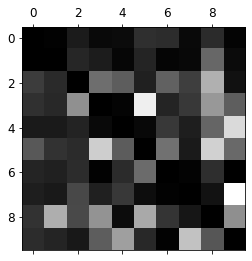

In [64]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(, cmap=plt.cm.gray)

plt.show()

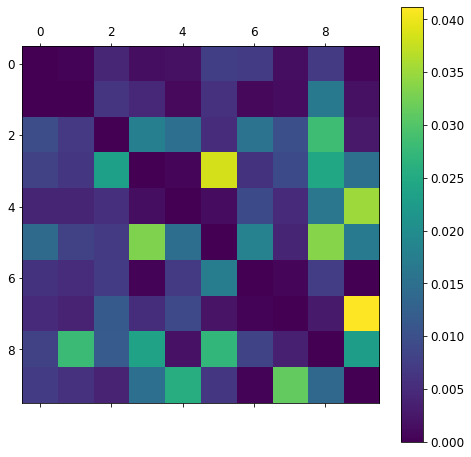

Nous pouvons clairement voir quelles erreurs sont faites par le classificateur (ne pas oublier que les lignes représentent les véritables classes, tandis que les colonnes représentent les classes prédites) :
- la colonne de la classe 8 est relativement claire, ce qui indique que beaucoup d'images sont identifiées par erreur comme des 8
- cependant, la ligne de la classe 8 n'est pas si mal, ce qui veut dire que les 8 sont généralement classés correctement comme des 8
- comme nous pouvons le voir, la matrice de confusion n'est pas nécessairement symétrique
- nous pouvons aussi voir que le 3 et les 5 sont souvent confondus, et ce dans les deux sens

Analyser les différentes erreurs peut être un bon moyen de comprendre ce que fait le classificateur et pourquoi il échoue, mais c'est plus difficile et plus long.

Imprimons par exemple des échantillons de 3 et de 5 à l'aide de la fonction `plot_digits()` :

In [66]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

Les deux blocs de gauche présentent des chiffres classés en 3, tandis que les deux blocs de droite présentent des images classées en 5.

Certains des chiffres sur lesquels le classificateur se trompe sont si mal écrits que même un humain aurait du mal à les classer ; néanmoins, la plupart des images mal classées nous paraissent être des erreurs évidentes.

L'explication est que nous avons utilisé un simple `SGDClassifier`, qui est un modèle linéaire : il ne fait qu'affecter un poids par classe à chaque pixel. Lorsqu'il reçoit une nouvelle image, il se contente d'ajouter les intensités pondérées des pixels pour obtenir un score pour chaque classe.

Etant donné sur les 3 et les 5 ne diffèrent que par quelques pixels, ce modèle les confondra aisément.

Un des moyens de réduire la confusion entre les 3 et les 5 consisterait à prétraiter les images afin qu'elles soient bien centrées et pas trop inclinées : cela contribuerait probablement à réduire également les autres erreurs.

### **7. CLASSIFICATION MULTI-ETIQUETTES**

Nous allons voir un exemple simple :

In [67]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = 
knn_clf.

KNeighborsClassifier()

Nous avons créé un tableau `y_multilabel` comportant deux étiquettes cibles pour chaque image numérique :
- la première indique si la valeur du chiffre est élevée (7, 8 ou 9)
- la seconde indique si cette valeur est impaire

Puis nous avons créé une instance de `KNeighborsClassifier` (qui autorise la classification multi-étiquettes, ce qui n'est pas le cas de tous les classificateurs) et l'avons entraîné sur le tableau d'étiquettes multiples.

Nous pouvons maintenant effectuer une prédiction :

In [68]:
knn_clf.

array([[False,  True]])

Nous obtenons deux étiquettes, qui s'avèrent correctes ! Le chiffre 5 n'a pas une valeur élevée (`False`) et est impair (`True`).

Il y a plusieurs façons d'évaluer un classificateur multi-étiquettes (la sélection de la bonne métrique dépend du projet) ; l'une des approches consiste à mesure le score $F_1$ pour chacune des étiquettes puis de calculer simplement le score moyen (**attention : cela peut prendre plusieurs heures en fonction de votre matériel !**) :

In [69]:
y_train_knn_pred = cross_val_predict(, , , cv=3, n_jobs=-1)


0.976410265560605

Nous venons de calculer le score $F_1$ moyen pour toutes les étiquettes.

*Remarque:*

- ceci suppose que toutes les étiquettes ont la même importance, ce qui n'est cependant pas forcément le cas
- une solution simple consisterait à donner à chaque étiquette un poids égal à son support (à savoir le nombre d'observations ayant cette étiquette cible) : pour ce faire, nous pourrions utiliser simplement l'option `average="weighted"` dans le code ci-dessus

### **8. CLASSIFICATION MULTI-SORTIES**

Nous allons construire un système qui supprime les aléas (ou bruit) des images :
- il reçoit en entrée une image numérique bruitée
- il transmet en sortie (espérons-le !) une image numérique propre, représentée par un tableau d'intensités de pixel, tout comme les images MNIST

La sortie du classificateur sera donc multi-étiquettes (une étiquette par pixel) et chaque étiquette pourra comporter plusieurs valeurs (l'intensité d'un pixel va de 0 à 255).

*Remarques :*
- la frontière entre classification et régression est plutôt floue, comme le montre cet exemple : prédire l'intensité d'un pixel s'apparente sans doute plus à une régression qu'à une classification
- les systèmes multi-sorties ne se limitent pas aux tâches de classification : nous pourrions même avoir un système qui renvoie plusieurs étiquettes par observation, incluant à la fois des étiquettes de classe et des étiquettes de valeur

Commençons par créer les jeux d'entraînement et de test en prenant les images MNIST et en utilisant la fonction `randint` de NumPy pour ajouter des aléas à leurs intensités de pixel (les images cibles seront les images d'origine) :

In [70]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + 
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + 
y_train_mod = X_train
y_test_mod = X_test

Jetons un coup d'oeil à une image du jeu de test (nous espionnons les données de test, cela devrait vous faire réagir !) :

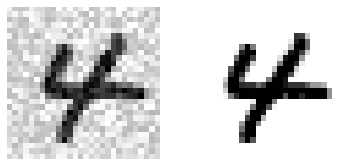

In [71]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

plt.show()

A gauche, l'image bruitée d'entrée et à droite, l'image propre ciblée.

Entraînons maintenant le classificateur et faisons-lui nettoyer l'image :

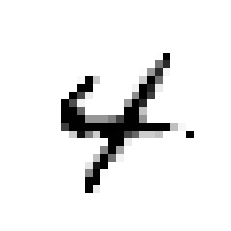

In [72]:
knn_clf.
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

C'est finalement assez proche du résultat souhaité.